# Nhận diện gương mặt với khẩu trang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install imutils

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import sys
import os
from imutils import paths

# Tiền xử lý dữ liệu

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [ ]:
# Đường dẫn đến thư mục 'dataset'
dataset = '/content/drive/MyDrive/Face_Mask_Detection/dataset'
imagePaths = list(paths.list_images(dataset))
len(imagePaths)

6000

In [ ]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

for i in imagePaths[-500:] + imagePaths[:500]:

    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)

    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224))
    image = img_to_array(image)

    # Chèn các dữ liệu ảnh vào list data
    data.append(image)

# mã hóa list dữ liệu thành định dạng mảng NumPy
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [ ]:
# In ra định dạng của tập dữ liệu data
data.shape, len(labels)

((1000, 224, 224, 3), 1000)

In [ ]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size=0.8, stratify=test_Y, random_state=0)

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [ ]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((500, 224, 224, 3), (500, 2), (400, 224, 224, 3), (400, 2))

# Khởi tạo và huấn luyện mô hình

Khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [ ]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')

## Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [ ]:
baseModel = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

## Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
# model.save('efficientnet.model')

Epoch 1/10
12/12 [==============================] - 61s 4s/step - loss: 0.1962 - accuracy: 0.9174 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 47s 4s/step - loss: 0.0980 - accuracy: 0.9826 - val_loss: 0.0262 - val_accuracy: 0.9900
Epoch 3/10
12/12 [==============================] - 46s 4s/step - loss: 0.0591 - accuracy: 0.9913 - val_loss: 0.0177 - val_accuracy: 0.9900
Epoch 4/10
12/12 [==============================] - 48s 4s/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 50s 4s/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 50s 4s/step - loss: 0.0374 - accuracy: 0.9917 - val_loss: 6.2653e-04 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 46s 4s/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 4.3872e-04 - val_accuracy: 1.0000
Epoch 8/10
1

- In ra lịch sử huấn luyện của mô hình

In [ ]:
H.history

{'loss': [0.19620956480503082,
  0.09798691421747208,
  0.05913384631276131,
  0.027941113337874413,
  0.04062172397971153,
  0.03737516328692436,
  0.02531292662024498,
  0.029593994840979576,
  0.0378953255712986,
  0.03149181604385376],
 'accuracy': [0.917391300201416,
  0.9826086759567261,
  0.991304337978363,
  0.991304337978363,
  0.987500011920929,
  0.9916666746139526,
  0.991304337978363,
  0.989130437374115,
  0.989130437374115,
  0.9869565367698669],
 'val_loss': [0.005156517494469881,
  0.02623520791530609,
  0.017668575048446655,
  0.008569090627133846,
  0.0033078345004469156,
  0.0006265278207138181,
  0.0004387164080981165,
  0.001137149054557085,
  0.0004955162876285613,
  0.0001964528055395931],
 'val_accuracy': [1.0,
  0.9900000095367432,
  0.9900000095367432,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

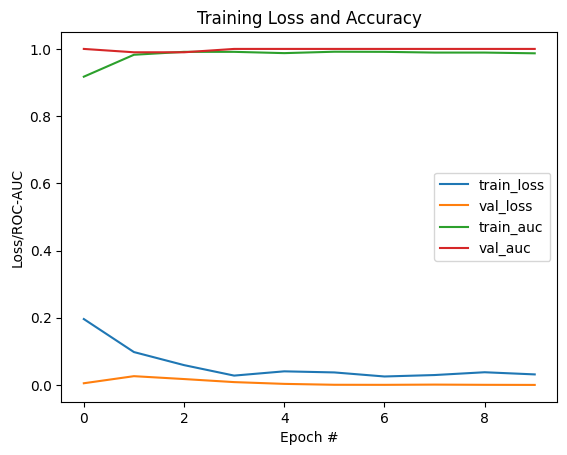

In [ ]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [ ]:
# !cp -R /content/drive/MyDrive/Face_Mask_Detection/mtcnn

In [ ]:
import cv2
os.chdir('/content/drive/MyDrive/Face_Mask_Detection/')

from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

detector = MtcnnDetector()

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được.

Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt.

Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn.

In [ ]:
def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""

    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)

    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [ ]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [ ]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue

choose = np.array(choose)

In [ ]:
test_X_align.shape

(400, 224, 224, 3)

In [ ]:
test_X_align[choose, :, :, :].shape

(240, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [ ]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [ ]:
predict = model.predict(test_X_align[choose])
predict = np.argmax(predict, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict)

8/8 [==============================] - 19s 2s/step


0.9797463175122748

## Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [ ]:
def mask_detect(image):

    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        # ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))

        # extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        # determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        # include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        # display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)

    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

1/1 [==============================] - 2s 2s/step


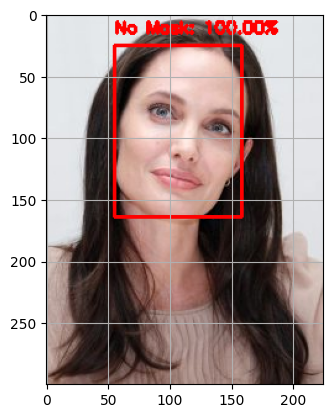

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/image/angelina.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

# cv2.imshow("OutPut",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 130ms/step


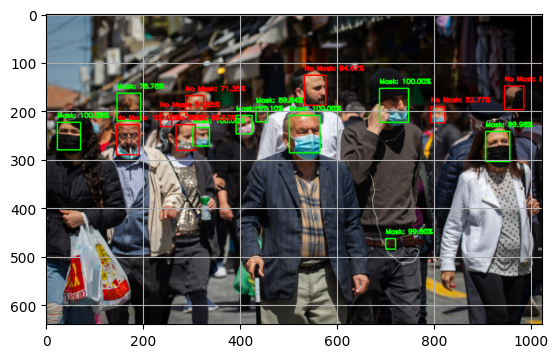

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/image/people.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

# cv2.imshow("OutPut",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 148ms/step


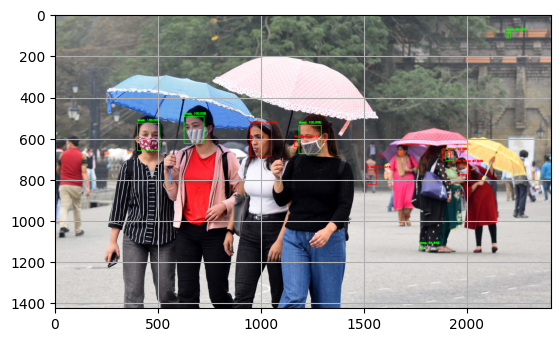

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/image/woman.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

# cv2.imshow("OutPut",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 96ms/step


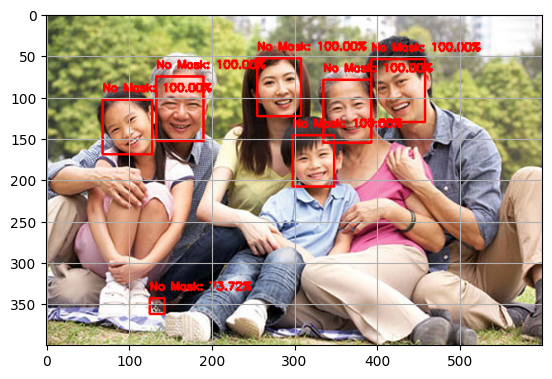

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/image/family.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

# cv2.imshow("OutPut",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()